# Detectron Test Harness
This notebook is used to get Detectron working

In [4]:
import torch
import torchvision

#
# Confirm environment is working as expected
#
print(f"PyTorch {torch.__version__}")
print(f"TorchVision {torchvision.__version__}")
print(f"NMS supported: {torchvision.ops.nms}")
print("-----------")
print(torch.cuda.get_device_name(0))
print(f"CUDA Version: {torch.version.cuda}")
print("-----------")
print("\n")
!jupyter labextension list


PyTorch 2.7.0+cu126
TorchVision 0.22.0+cu126
NMS supported: <function nms at 0x7fce8cbfa480>
-----------
NVIDIA RTX 6000 Ada Generation
CUDA Version: 12.6
-----------


JupyterLab v4.4.1
/usr/local/share/jupyter/labextensions
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        @jupyter-widgets/jupyterlab-manager v5.0.14 enabled OK (python, jupyterlab_widgets)
        @jupyterhub/jupyter-server-proxy v4.4.0 enabled OK
        @jupyterlab/mathjax2-extension v4.0.0 enabled OK (python, jupyterlab_mathjax2)



In [3]:
import os
import requests
from tqdm.notebook import tqdm

#
# This downloads the MaskRCNN pretrained file - thats it...
#

def download_file(uri: str, local_path: str) -> None:
    if not os.path.exists(local_path):
        response = requests.get(uri, stream=True)
        response.raise_for_status()  # Raise an error for bad responses
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192
        with open(local_path, "wb") as file, tqdm(
            total=total_size, 
            unit="B", 
            unit_scale=True, 
            desc=local_path
        ) as progress :
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    file.write(chunk)
                    progress.update(len(chunk))


pretrained="https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl"
download_file(pretrained, "/project/data/model_final_a3ec72.pkl")



/project/data/model_final_a3ec72.pkl:   0%|          | 0.00/254M [00:00<?, ?B/s]

INFO:datasets:PyTorch version 2.7.0 available.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (BVRA/wildlife-mega-L-384)
INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /project/data/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /project/data/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'
/usr/local/lib/python3.13/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model load complete...
Input image details: Max=151.47000122070312 Min=-123.67500305175781 shape=torch.Size([3, 384, 384])
Render image details: max=255 min=0 shape=(384, 384, 3)


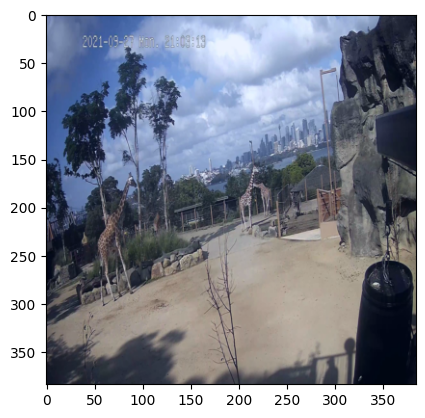

Available fields in the result: pred_boxes,scores,pred_classes,pred_masks
Boxes:
Class: 23 Score: 0.7783065438270569 = tensor([ 50.0399, 169.1932,  84.4528, 291.9251])
Class: 0 Score: 0.6513100862503052 = tensor([257.7666, 181.9116, 265.6893, 209.6376])
Class: 12 Score: 0.24523857235908508 = tensor([312.4051, 252.8783, 382.3550, 382.2086])
Class: 0 Score: 0.20595243573188782 = tensor([254.5983, 182.4327, 261.8331, 204.0988])
Class: 0 Score: 0.14721614122390747 = tensor([302.1085, 197.2951, 315.8981, 243.7449])
Class: 0 Score: 0.09017068147659302 = tensor([258.0137, 194.0826, 264.8332, 209.5779])
Class: 23 Score: 0.08880068361759186 = tensor([201.6629, 179.5815, 215.2507, 210.9003])
Class: 0 Score: 0.0820397436618805 = tensor([260.5842, 183.5248, 266.4080, 200.7841])
Class: 0 Score: 0.05477052554488182 = tensor([253.9813, 181.7079, 264.1583, 212.5440])
Class: 23 Score: 0.05288634076714516 = tensor([198.9218, 154.1788, 228.2665, 219.2230])
Class: 23 Score: 0.05094444751739502 = tensor([2

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [1]:
from welfareobs.detectron.detectron_configuration import get_configuration
from welfareobs.detectron.detectron_calls import image_loader, predict
from detectron2.config import instantiate
from detectron2.checkpoint import DetectionCheckpointer

# Instantiate the model configuration (this embeds the feature extraction)
# NOTE: the `root` path contains checkpoints we have trained on features
# files that should exist in the root are:
# * "checkpoint.pth" <-- weights of the finetuned backbone
# * "similarity.pkl" <-- deep features mapping file (maps to the finetuning training set classes)
dimensions = 384
model = instantiate(
    get_configuration(
        "/project/data/results/wod-md",
        backbone="hf-hub:BVRA/wildlife-mega-L-384",
        dimensions=dimensions
    )
)
# then load it with the pretrained backbone
DetectionCheckpointer(model).load("/project/data/model_final_a3ec72.pkl")
model.eval()
model.to("cuda")
print("Model load complete...")

#
# Prediction 
#
output = predict(
    [
        image_loader(
            "/project/data/wod_reid/images/c1-savannah-2024_03_26__23_03_54.jpg",
            384
        ),
        image_loader(
            "/project/data/wod_reid/images/c2-savannah-2024_02_21__04_07_46.jpg",
            384
        ),    
    ],
    model
)

# #
# # Inspect
# #
# output = output["instances"][0]
# print(f"Output type is {type(output)}")
# print(f"Available fields in the result: {','.join([o for o in output.get_fields().keys()])}")
# _reids = list(output.get("reid_embeddings").cpu().numpy().flatten())
# _classes = list(output.get("pred_classes").cpu().numpy())
# _boxes = list(output.get("pred_boxes").cpu().numpy())
# _masks = list(output.get("pred_masks").cpu().numpy())
# _scores = list(output.get("scores").cpu().numpy())
# for i in range(len(output)):
#     if _classes[i] == 23:
#         print(f"Giraffe: {_reids[i]} score={_scores[i]}")





In [ ]:
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data.catalog import MetadataCatalog
from detectron2.structures import Instances, Boxes


metadata = MetadataCatalog.get("coco_2017_val")
# Convert image to float and scale to [0, 1] for matplotlib
image = np.array(Image.open("20230920_091213.jpg").convert("RGB").resize((384, 384), Image.LANCZOS))
image_rgb = image.astype(np.float32) / 255.0
v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)

giraffe_mask = output.pred_classes == 23
filtered_instances = Instances((384, 384), **{
    "pred_boxes": output.pred_boxes[giraffe_mask],
    "scores": output.scores[giraffe_mask],
    "pred_classes": output.pred_classes[giraffe_mask]
})
out = v.draw_instance_predictions(filtered_instances.to("cpu"))
output_image = out.get_image()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(output_image[:, :, ::-1])
axes[1].set_title("Output Image with Predictions")
axes[1].axis("off")
plt.axis("off")
plt.show()